# Setup

In [1]:
include(joinpath("..","src","setup.jl"))

datadir = joinpath("..","data","count_lengths","run_2018-11-15")

┌ Warning: Package RCall does not have AxisArrays in its dependencies:
│ - If you have RCall checked out for development and have
│   added AxisArrays as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with RCall
│ Loading AxisArrays into RCall from project dependency, future warnings for RCall are suppressed.
└ @ nothing nothing:840
┌ Info: Recompiling stale cache file /Users/davidlittle/.julia/compiled/v1.0/AuditoryBistabilityLE/RqG8S.ji for AuditoryBistabilityLE [7e25a372-ade5-11e8-17af-a30e5a9e2c28]
└ @ Base loading.jl:1190


┌ Warning: RCall.jl: Need help? Try Stackoverflow: https://stackoverflow.com/tags/ggplot2.
└ @ RCall /Users/davidlittle/.julia/packages/RCall/RPlFw/src/io.jl:110


"../data/count_lengths/run_2018-11-15"

# TODO:
- combine all of these plots together
- make it possible to call this combined plot on a given set of parameter values
- define an RMS measure on the basis of the histogram alone?
- start taking a look at the new data (from the 11-16 run)

# Questions

Why does bistability arise with no adaptation for the scale-level? (or the object level?)

# Load data

In [244]:
params = load(joinpath(datadir,"params.jld2"),"params")
params[:pindex] = 1:size(params,1)
settings = joinpath("..","src","settings.toml")

results = []
for_results_in(joinpath(datadir,"data")) do entry
  # lengths, percepts = percept_lengths(audiospect(entry["mask"],settings),params[entry["pindex"],:],settings)
  # push!(results,DataFrame(length=lengths,percepts=percepts.+1,created=entry["created"],pindex=entry["pindex"]))
  
  push!(results,DataFrame(length=entry["lengths"],
                           percepts=entry["percepts"].+1, # after +1, indicates the number of streams reported, 1 or 2
                           created=entry["created"],
                           pindex=entry["pindex"])) # the parameter index (pindex = N correspondes to row N of `params`)
end
df = vcat(results...)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


50343×4 DataFrame
│ Row   │ length  │ percepts │ created                 │ pindex │
│       │ Float64 │ Int64    │ DateTime                │ Int64  │
├───────┼─────────┼──────────┼─────────────────────────┼────────┤
│ 1     │ 1.2     │ 2        │ 2018-11-16T07:26:05.832 │ 1      │
│ 2     │ 46.1    │ 1        │ 2018-11-16T07:26:05.832 │ 1      │
│ 3     │ 0.8     │ 2        │ 2018-11-16T07:27:25.012 │ 1      │
│ 4     │ 19.2    │ 1        │ 2018-11-16T07:27:25.012 │ 1      │
│ 5     │ 1.1     │ 2        │ 2018-11-16T07:27:25.012 │ 1      │
│ 6     │ 9.0     │ 1        │ 2018-11-16T07:27:25.012 │ 1      │
│ 7     │ 0.9     │ 2        │ 2018-11-16T07:27:25.012 │ 1      │
│ 8     │ 16.3    │ 1        │ 2018-11-16T07:27:25.012 │ 1      │
│ 9     │ 1.2     │ 2        │ 2018-11-16T07:27:30.568 │ 1      │
│ 10    │ 29.6    │ 1        │ 2018-11-16T07:27:30.568 │ 1      │
⋮
│ 50333 │ 6.0     │ 2        │ 2018-11-16T07:43:49.717 │ 225    │
│ 50334 │ 1.7     │ 1        │ 2018-11-16T07:43:49.717 │ 225    │
│ 50335 │ 1.6     │ 2        │ 2018-11-16T07:43:49.717 │ 225    │
│ 50336 │ 1.8     │ 1        │ 2018-11-16T07:43:49.717 │ 225    │
│ 50337 │ 1.6     │ 2        │ 2018-11-16T07:43:49.717 │ 225    │
│ 50338 │ 1.3     │ 1        │ 2018-11-16T07:43:49.717 │ 225    │
│ 50339 │ 4.9     │ 2        │ 2018-11-16T07:43:49.717 │ 225    │
│ 50340 │ 0.8     │ 1        │ 2018-11-16T07:43:49.717 │ 225    │
│ 50341 │ 5.0     │ 2        │ 2018-11-16T07:43:49.717 │ 225    │
│ 50342 │ 0.8     │ 1        │ 2018-11-16T07:43:49.717 │ 225    │
│ 50343 │ 1.0     │ 2        │ 2018-11-16T07:43:49.717 │ 225    │

In [3]:
sim_length = jldopen(joinpath(datadir,"data",readdir(joinpath(datadir,"data"))[1]),"r") do first_file
    last(first_file["btimes_s"])
end

47.6

# proportion streaming

In [4]:
function handlebound(fn,seconds;bound=true,threshold=0.8)
    if bound && length(seconds) < 3
        return missing
    end
    
    if !bound || (sum(seconds[2:end-1]) > threshold*sum(seconds))
        fn(1:length(seconds))
    else
        fn(2:length(seconds)-1)
    end
end

handlebound (generic function with 1 method)

In [5]:
function streamprop(percepts,seconds;kwds...)
    handlebound(seconds;kwds...) do range
        sum(seconds[range][percepts[range] .== 2]) / sum(seconds[range])
    end
end

streamprop (generic function with 1 method)

In [6]:
function stim_per_second(seconds;kwds...)
    handlebound(seconds;kwds...) do range
        length(range) / sim_length
    end
end
        

stim_per_second (generic function with 1 method)

In [31]:
df_summary = @linq df |>
  by(:pindex,
     num_sims = length(unique(:created)),
     stim_rate = stim_per_second(:length),
     skew = skewness(log.(:length)),
     kurt = kurtosis(log.(:length)),
     streamprop = streamprop(:percepts,:length,bound=true)) |>
  join(params,on = :pindex) |>
  transform(f_c_a = round.(:f_c_a), f_c_m = round.(:f_c_m),
            s_c_a = round.(:s_c_a), s_c_m = round.(:s_c_m),
            t_c_a = round.(:t_c_a), t_c_m = round.(:t_c_m))

225×41 DataFrame. Omitted printing of 35 columns
│ Row │ pindex │ num_sims │ stim_rate │ skew        │ kurt       │ streamprop │
│     │ Int64  │ Int64    │ Float64   │ Float64     │ Float64    │ Float64    │
├─────┼────────┼──────────┼───────────┼─────────────┼────────────┼────────────┤
│ 1   │ 1      │ 20       │ 12.3077   │ 0.269447    │ -1.52299   │ 0.038055   │
│ 2   │ 2      │ 20       │ 8.30769   │ -0.433541   │ -1.44533   │ 0.0142706  │
│ 3   │ 3      │ 20       │ 10.4615   │ -0.00736653 │ -1.54166   │ 0.0321353  │
│ 4   │ 4      │ 20       │ 10.1538   │ 0.161583    │ -1.6692    │ 0.0412262  │
│ 5   │ 5      │ 20       │ 5.53846   │ -0.271639   │ -1.84606   │ 0.0127907  │
│ 6   │ 6      │ 20       │ 6.15385   │ -0.701588   │ -1.19721   │ 0.00909091 │
│ 7   │ 7      │ 20       │ 10.1538   │ -0.318221   │ -1.54727   │ 0.0252643  │
│ 8   │ 8      │ 20       │ 17.2308   │ 0.104569    │ -1.38492   │ 0.0551797  │
│ 9   │ 9      │ 20       │ 19.6923   │ 0.105881    │ -1.43801   │ 0.0604651  │
│ 10  │ 10     │ 20       │ 25.2308   │ 0.188885    │ -1.3899    │ 0.0835095  │
⋮
│ 215 │ 215    │ 20       │ 71.2308   │ 0.897702    │ 0.0353543  │ 0.745983   │
│ 216 │ 216    │ 20       │ 3.38462   │ -3.85016    │ 13.7739    │ 0.999154   │
│ 217 │ 217    │ 20       │ 58.4615   │ 0.947705    │ 0.280423   │ 0.814059   │
│ 218 │ 218    │ 20       │ 81.0769   │ 1.14898     │ 0.356199   │ 0.77981    │
│ 219 │ 219    │ 20       │ 66.6154   │ 0.729294    │ -0.0140435 │ 0.728224   │
│ 220 │ 220    │ 20       │ 70.7692   │ 0.769798    │ -0.0519928 │ 0.692812   │
│ 221 │ 221    │ 20       │ 3.07692   │ 1.0         │ -2.0       │ 1.0        │
│ 222 │ 222    │ 20       │ 58.7692   │ 0.671358    │ -0.518898  │ 0.828753   │
│ 223 │ 223    │ 20       │ 57.2308   │ 0.873285    │ -0.364194  │ 0.839746   │
│ 224 │ 224    │ 20       │ 77.8462   │ 0.751544    │ -0.514387  │ 0.718605   │
│ 225 │ 225    │ 20       │ 67.0769   │ 0.603837    │ -0.528793  │ 0.729175   │

WARN column encoding should be discrete (ordinal / nominal / binned).
WARN column encoding should be discrete (ordinal / nominal / binned).


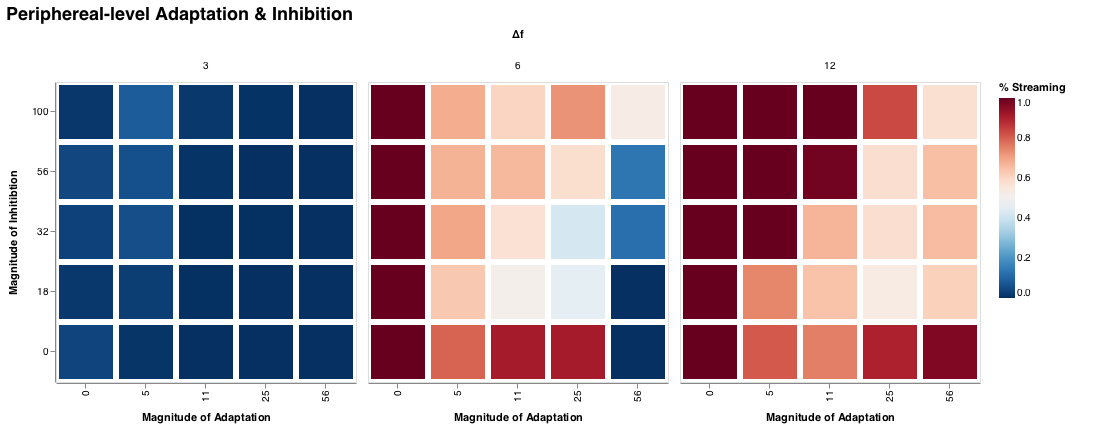

In [32]:
@where(df_summary,:f_c_σ .> 0) |>
  @vlplot(:rect, width=300, height=300,
          title={text="Periphereal-level Adaptation & Inhibition",fontSize=18},
          column=:Δf,
          x={field=:f_c_a, typ="ordinal", sort = "ascending",
             axis={title="Magnitude of Adaptation"}},
          y={field=:f_c_m, typ="ordinal", sort = "descending",
             axis={title="Magnitude of Inhitibtion"}},
          color={field="streamprop", aggregate="mean", typ="quantitative",
                 sort = "descending",scale={domain=[0,1],range="diverging"},
                 legend={title="% Streaming"}},
          config={range={diverging={scheme="redblue"}}})

WARN column encoding should be discrete (ordinal / nominal / binned).
WARN column encoding should be discrete (ordinal / nominal / binned).


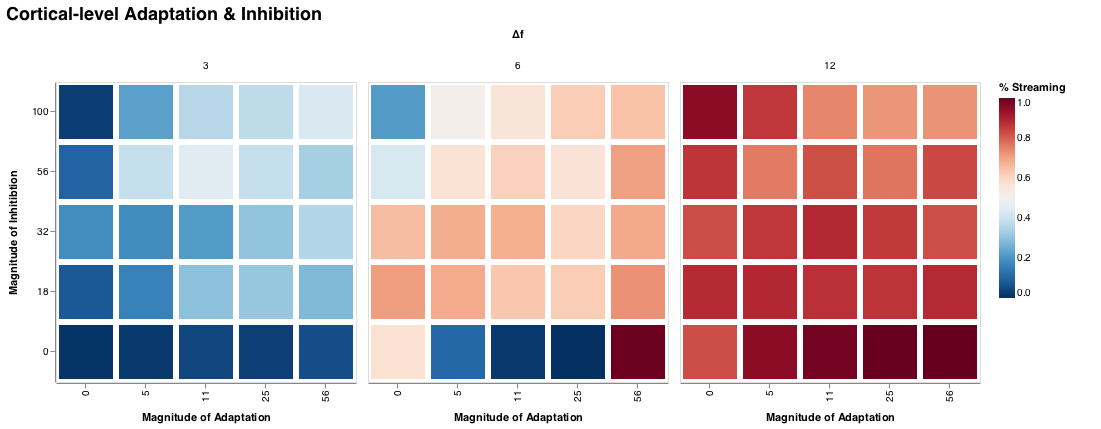

In [33]:
@where(df_summary,:s_c_σ .> 0) |>
  @vlplot(:rect, width=300, height=300,
          title={text="Cortical-level Adaptation & Inhibition",fontSize=18},
          column=:Δf,
          x={field=:s_c_a, typ="ordinal", sort = "ascending",
             axis={title="Magnitude of Adaptation"}},
          y={field=:s_c_m, typ="ordinal", sort = "descending",
             axis={title="Magnitude of Inhitibtion"}},
          color={field="streamprop", aggregate="mean", typ="quantitative",
                 sort = "descending",scale={domain=[0,1],range="diverging"},
                 legend={title="% Streaming"}},
          config={range={diverging={scheme="redblue"}}})

WARN column encoding should be discrete (ordinal / nominal / binned).
WARN column encoding should be discrete (ordinal / nominal / binned).


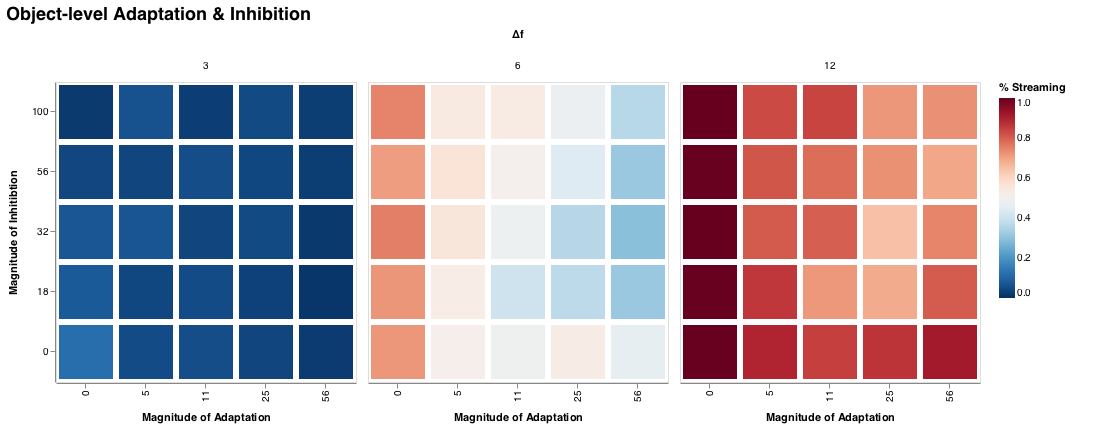

In [34]:
@where(df_summary,:t_c_σ .> 0) |>
  @vlplot(:rect, width=300, height=300,
          title={text="Object-level Adaptation & Inhibition",fontSize=18},
          column=:Δf,
          x={field=:t_c_a, typ="ordinal", sort = "ascending",
             axis={title="Magnitude of Adaptation"}},
          y={field=:t_c_m, typ="ordinal", sort = "descending",
             axis={title="Magnitude of Inhitibtion"}},
          color={field="streamprop", aggregate="mean", typ="quantitative",
                 sort = "descending",scale={domain=[0,1],range="diverging"},
                 legend={title="% Streaming"}},
          config={range={diverging={scheme="redblue"}}})

# RMS of streaming selectivity

In [12]:
mean_human = [0.11, 0.55, 0.89]
function stream_rms(str3,str6,str12)
  vec(sqrt.(mean((hcat(str3,str6,str12) .- mean_human').^2,dims=2)))
end

stream_rms (generic function with 1 method)

In [13]:
function rename_levels_for(df,val)
    df[:c_m] = NaN
    df[:c_a] = NaN
    df[:level] = "unknown"
    @byrow! df begin
        if :f_c_σ > 0 
           :level = "Peripheral"
            :c_m = :f_c_m
            :c_a = :f_c_a
        elseif :s_c_σ > 0 
            :level = "Cortical"
            :c_m = :s_c_m
            :c_a = :s_c_a
        elseif :t_c_σ > 0 
            :level = "Object"
            :c_m = :t_c_m
            :c_a = :t_c_a
        end
    end
    df[[:c_m,:c_a,:level,val]]
end
        
DataFramesMeta.linq(::DataFramesMeta.SymbolParameter{:rename_levels}, df, val) = :(rename_levels($df,$val))

In [37]:
df_stream_rms = @linq df_summary |>
  select(:f_c_σ,:f_c_a,:f_c_m,:s_c_σ,:s_c_a,:s_c_m,:t_c_σ,:t_c_a,:t_c_m,:Δf,:streamprop) |>
  unstack(:Δf,:streamprop) |>
  rename(Symbol("3") => :Δf_3,Symbol("6") => :Δf_6,Symbol("12") => :Δf_12) |>
  transform(stream_rms = stream_rms(:Δf_3,:Δf_6,:Δf_12)) |>
  rename_levels_for(:stream_rms)

75×4 DataFrame
│ Row │ c_m     │ c_a     │ level      │ stream_rms │
│     │ Float64 │ Float64 │ String     │ Float64    │
├─────┼─────────┼─────────┼────────────┼────────────┤
│ 1   │ 0.0     │ 0.0     │ Object     │ 0.116075   │
│ 2   │ 18.0    │ 0.0     │ Object     │ 0.117985   │
│ 3   │ 32.0    │ 0.0     │ Object     │ 0.136035   │
│ 4   │ 56.0    │ 0.0     │ Object     │ 0.117844   │
│ 5   │ 100.0   │ 0.0     │ Object     │ 0.140653   │
│ 6   │ 0.0     │ 5.0     │ Object     │ 0.039396   │
│ 7   │ 18.0    │ 5.0     │ Object     │ 0.0441584  │
│ 8   │ 32.0    │ 5.0     │ Object     │ 0.0536586  │
│ 9   │ 56.0    │ 5.0     │ Object     │ 0.0601327  │
│ 10  │ 100.0   │ 5.0     │ Object     │ 0.0446225  │
⋮
│ 65  │ 100.0   │ 11.0    │ Peripheral │ 0.0900324  │
│ 66  │ 0.0     │ 25.0    │ Peripheral │ 0.218396   │
│ 67  │ 18.0    │ 25.0    │ Peripheral │ 0.222436   │
│ 68  │ 32.0    │ 25.0    │ Peripheral │ 0.206045   │
│ 69  │ 56.0    │ 25.0    │ Peripheral │ 0.190695   │
│ 70  │ 100.0   │ 25.0    │ Peripheral │ 0.122319   │
│ 71  │ 0.0     │ 56.0    │ Peripheral │ 0.32687    │
│ 72  │ 18.0    │ 56.0    │ Peripheral │ 0.361439   │
│ 73  │ 32.0    │ 56.0    │ Peripheral │ 0.288992   │
│ 74  │ 56.0    │ 56.0    │ Peripheral │ 0.282932   │
│ 75  │ 100.0   │ 56.0    │ Peripheral │ 0.192094   │

In [38]:
df_stim_rate |>
  @vlplot(:rect, width=300, height=300,
          title={text="Stimulus Rate",fontSize=18},
          column={field=:level, typ="nominal", sort=["Peripheral", "Cortical", "Object"]},
          x={field=:c_a, typ="ordinal", sort = "ascending",
             axis={title="Magnitude of Adaptation"}},
          y={field=:c_m, typ="ordinal", sort = "descending",
             axis={title="Magnitude of Inhitibtion"}},
          color={field=:stim_rate, aggregate="mean", typ="quantitative", 
                 legend={title="Stimuli / Second"}},
          config={range={heatmap={scheme="viridis"}}})

UndefVarError: UndefVarError: df_stim_rate not defined

In [41]:
df_stream_rms2 = unstack(df_stream_rms,[:c_m,:c_a],:level,:stream_rms)

25×5 DataFrame
│ Row │ c_m     │ c_a     │ Cortical  │ Object    │ Peripheral │
│     │ Float64 │ Float64 │ Float64⍰  │ Float64⍰  │ Float64⍰   │
├─────┼─────────┼─────────┼───────────┼───────────┼────────────┤
│ 1   │ 0.0     │ 0.0     │ 0.0718478 │ 0.116075  │ 0.270663   │
│ 2   │ 0.0     │ 5.0     │ 0.263898  │ 0.039396  │ 0.159878   │
│ 3   │ 0.0     │ 11.0    │ 0.316218  │ 0.0554786 │ 0.23121    │
│ 4   │ 0.0     │ 25.0    │ 0.326444  │ 0.0448578 │ 0.218396   │
│ 5   │ 0.0     │ 56.0    │ 0.265293  │ 0.074608  │ 0.32687    │
│ 6   │ 18.0    │ 0.0     │ 0.0932672 │ 0.117985  │ 0.273108   │
│ 7   │ 18.0    │ 5.0     │ 0.0846517 │ 0.0441584 │ 0.108602   │
│ 8   │ 18.0    │ 11.0    │ 0.119732  │ 0.136058  │ 0.157569   │
│ 9   │ 18.0    │ 25.0    │ 0.123739  │ 0.163833  │ 0.222436   │
│ 10  │ 18.0    │ 56.0    │ 0.141401  │ 0.155195  │ 0.361439   │
⋮
│ 15  │ 32.0    │ 56.0    │ 0.166672  │ 0.177826  │ 0.288992   │
│ 16  │ 56.0    │ 0.0     │ 0.0752598 │ 0.117844  │ 0.270389   │
│ 17  │ 56.0    │ 5.0     │ 0.1767    │ 0.0601327 │ 0.0989231  │
│ 18  │ 56.0    │ 11.0    │ 0.1997    │ 0.0751201 │ 0.10335    │
│ 19  │ 56.0    │ 25.0    │ 0.174328  │ 0.119698  │ 0.190695   │
│ 20  │ 56.0    │ 56.0    │ 0.16034   │ 0.184073  │ 0.282932   │
│ 21  │ 100.0   │ 0.0     │ 0.202067  │ 0.140653  │ 0.273282   │
│ 22  │ 100.0   │ 5.0     │ 0.0720142 │ 0.0446225 │ 0.100713   │
│ 23  │ 100.0   │ 11.0    │ 0.167092  │ 0.0570414 │ 0.0900324  │
│ 24  │ 100.0   │ 25.0    │ 0.18556   │ 0.11287   │ 0.122319   │
│ 25  │ 100.0   │ 56.0    │ 0.21411   │ 0.151618  │ 0.192094   │

In [42]:
CSV.write("df_stream_test.csv",df_stream_rms2)

UndefVarError: UndefVarError: CSV not defined

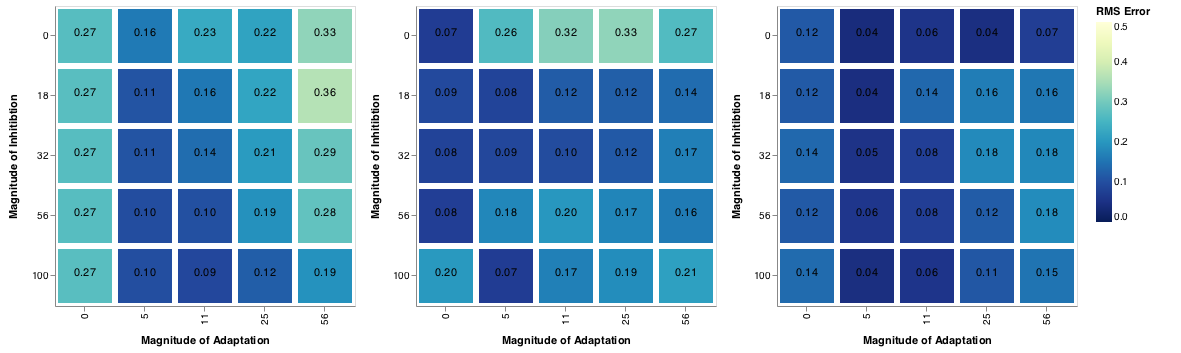

In [43]:
df_stream_rms2 |>
  @vlplot(repeat={column=["Peripheral","Cortical","Object"]},
    config={range={heatmap={scheme="yellowgreenblue"}}}) +
  (@vlplot() +
   @vlplot(:rect, width=300, height=300,
           x={field=:c_a, typ="ordinal", 
              axis={title="Magnitude of Adaptation"}},
           y={field=:c_m, typ="ordinal",
              axis={title="Magnitude of Inhitibtion"}},
           color={field={repeat="column"}, aggregate="mean", typ="quantitative", sort = "descending",
                  legend={title="RMS Error"}, scale={domain=[0,0.5]}}) +
   @vlplot(:text, width=300, height=300,
           x={field=:c_a, typ="ordinal", 
              axis={title="Magnitude of Adaptation"}},
           y={field=:c_m, typ="ordinal", 
              axis={title="Magnitude of Inhitibtion"}},
           text={field={repeat="column"}, aggregate="mean", typ="quantitative", format=".2f"}))

# Count

In [19]:
df_stim_rate = @linq df_summary |>
  where(:Δf .== 6) |>
  select(:f_c_σ,:f_c_a,:f_c_m,:s_c_σ,:s_c_a,:s_c_m,:t_c_σ,:t_c_a,:t_c_m,:stim_rate) |>
  rename_levels_for(:stim_rate);

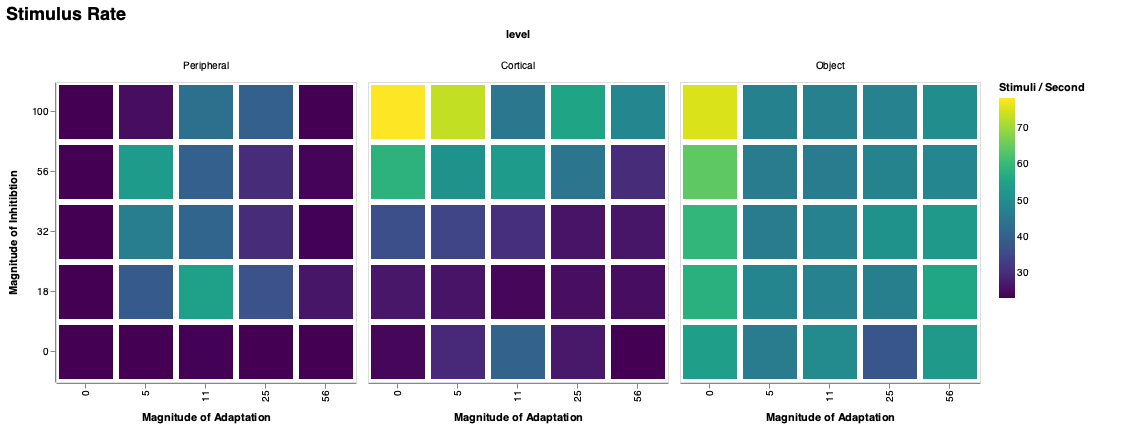

In [49]:
df_stim_rate |>
  @vlplot(:rect, width=300, height=300,
          title={text="Stimulus Rate",fontSize=18},
          column={field=:level, typ="nominal", sort=["Peripheral", "Cortical", "Object"]},
          x={field=:c_a, typ="ordinal", sort = "ascending",
             axis={title="Magnitude of Adaptation"}},
          y={field=:c_m, typ="ordinal", sort = "descending",
             axis={title="Magnitude of Inhitibtion"}},
          color={field=:stim_rate, aggregate="mean", typ="quantitative", 
                 legend={title="Stimuli / Second"}},
          config={range={heatmap={scheme="viridis"}}})

# Log Normality

In [44]:
df_skew = @linq df_summary |>
  where(:Δf .== 6) |>
  select(:f_c_σ,:f_c_a,:f_c_m,:s_c_σ,:s_c_a,:s_c_m,:t_c_σ,:t_c_a,:t_c_m,:skew) |>
  rename_levels_for(:skew);

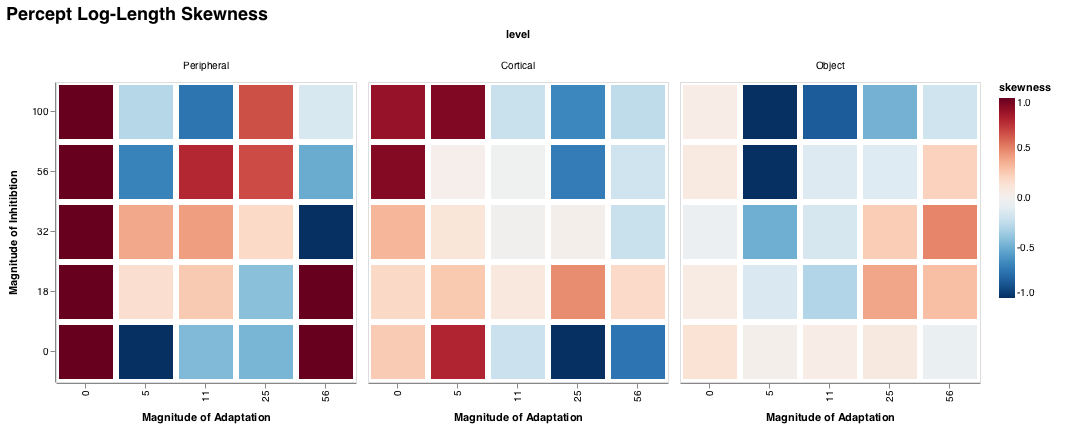

In [45]:
df_skew |>
  @vlplot(:rect, width=300, height=300,
          title={text="Percept Log-Length Skewness",fontSize=18},
          column={field=:level, typ="nominal", sort=["Peripheral", "Cortical", "Object"]},
          x={field=:c_a, typ="ordinal", sort = "ascending",
             axis={title="Magnitude of Adaptation"}},
          y={field=:c_m, typ="ordinal", sort = "descending",
             axis={title="Magnitude of Inhitibtion"}},
          color={field="skew", aggregate="mean", typ="quantitative",
                 sort = "descending",scale={domain=[-1,1],range="diverging"},
                 legend={title="skewness"}},
          config={range={diverging={scheme="redblue"}}})

# Kurtosis

In [46]:
df_kurt = @linq df_summary |>
  where(:Δf .== 6) |>
  select(:f_c_σ,:f_c_a,:f_c_m,:s_c_σ,:s_c_a,:s_c_m,:t_c_σ,:t_c_a,:t_c_m,:kurt) |>
  rename_levels_for(:kurt);

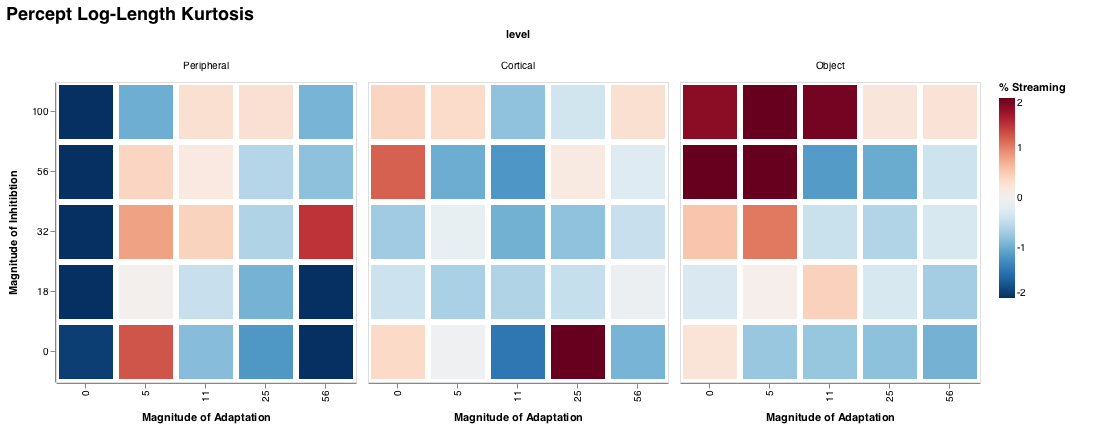

In [47]:
df_kurt |>
  @vlplot(:rect, width=300, height=300,
          title={text="Percept Log-Length Kurtosis",fontSize=18},
          column={field=:level, typ="nominal", sort=["Peripheral", "Cortical", "Object"]},
          x={field=:c_a, typ="ordinal", sort = "ascending",
             axis={title="Magnitude of Adaptation"}},
          y={field=:c_m, typ="ordinal", sort = "descending",
             axis={title="Magnitude of Inhitibtion"}},
          color={field="kurt", aggregate="mean", typ="quantitative",
                 sort = "descending",scale={domain=[-2,2],range="diverging"},
                 legend={title="% Streaming"}},
          config={range={diverging={scheme="redblue"}}})

I need to examine the distribution at 100 T_m, 11 T_a to see what's up with that distribution. Is it that the short trial time is making a large bar at 6.72 s?

# Overal RMS

In [48]:
rms(x) = any(isnan,x) ? 100 : sqrt(mean(x.^2))

rms (generic function with 1 method)

In [49]:
df_combined = join(df_stream_rms,df_skew,on = [:c_m,:c_a,:level])
df_combined = join(df_combined,df_kurt,on = [:c_m,:c_a,:level])

# for our purposes here we are going to say a kurtosis of 2, a skewness of 1, and a stream deviation of 0.5 are equivalent
# in the final analysis, we should z-score these statistics based on the human data
df_combined = @transform(df_combined,rms = vec(mapslices(rms,[:stream_rms./0.5 :skew./2 :kurt./2],dims=2)))

75×7 DataFrame. Omitted printing of 1 columns
│ Row │ c_m     │ c_a     │ level      │ stream_rms │ skew       │ kurt      │
│     │ Float64 │ Float64 │ String     │ Float64    │ Float64    │ Float64   │
├─────┼─────────┼─────────┼────────────┼────────────┼────────────┼───────────┤
│ 1   │ 0.0     │ 0.0     │ Object     │ 0.116075   │ 0.141031   │ 0.244428  │
│ 2   │ 18.0    │ 0.0     │ Object     │ 0.117985   │ 0.0693232  │ -0.285974 │
│ 3   │ 32.0    │ 0.0     │ Object     │ 0.136035   │ -0.0440262 │ 0.549101  │
│ 4   │ 56.0    │ 0.0     │ Object     │ 0.117844   │ 0.0831086  │ 2.52319   │
│ 5   │ 100.0   │ 0.0     │ Object     │ 0.140653   │ 0.0587845  │ 1.80992   │
│ 6   │ 0.0     │ 5.0     │ Object     │ 0.039396   │ 0.0268693  │ -0.751873 │
│ 7   │ 18.0    │ 5.0     │ Object     │ 0.0441584  │ -0.14268   │ 0.0659286 │
│ 8   │ 32.0    │ 5.0     │ Object     │ 0.0536586  │ -0.487781  │ 1.05283   │
│ 9   │ 56.0    │ 5.0     │ Object     │ 0.0601327  │ -1.10732   │ 2.95383   │
│ 10  │ 100.0   │ 5.0     │ Object     │ 0.0446225  │ -1.4121    │ 3.46709   │
⋮
│ 65  │ 100.0   │ 11.0    │ Peripheral │ 0.0900324  │ -0.731333  │ 0.304021  │
│ 66  │ 0.0     │ 25.0    │ Peripheral │ 0.218396   │ -0.461219  │ -1.16688  │
│ 67  │ 18.0    │ 25.0    │ Peripheral │ 0.222436   │ -0.411708  │ -0.946736 │
│ 68  │ 32.0    │ 25.0    │ Peripheral │ 0.206045   │ 0.184462   │ -0.602384 │
│ 69  │ 56.0    │ 25.0    │ Peripheral │ 0.190695   │ 0.655218   │ -0.578183 │
│ 70  │ 100.0   │ 25.0    │ Peripheral │ 0.122319   │ 0.644826   │ 0.298     │
│ 71  │ 0.0     │ 56.0    │ Peripheral │ 0.32687    │ 1.0        │ -2.0      │
│ 72  │ 18.0    │ 56.0    │ Peripheral │ 0.361439   │ 1.0        │ -2.0      │
│ 73  │ 32.0    │ 56.0    │ Peripheral │ 0.288992   │ -1.81792   │ 1.45949   │
│ 74  │ 56.0    │ 56.0    │ Peripheral │ 0.282932   │ -0.50388   │ -0.809641 │
│ 75  │ 100.0   │ 56.0    │ Peripheral │ 0.192094   │ -0.154341  │ -0.930294 │

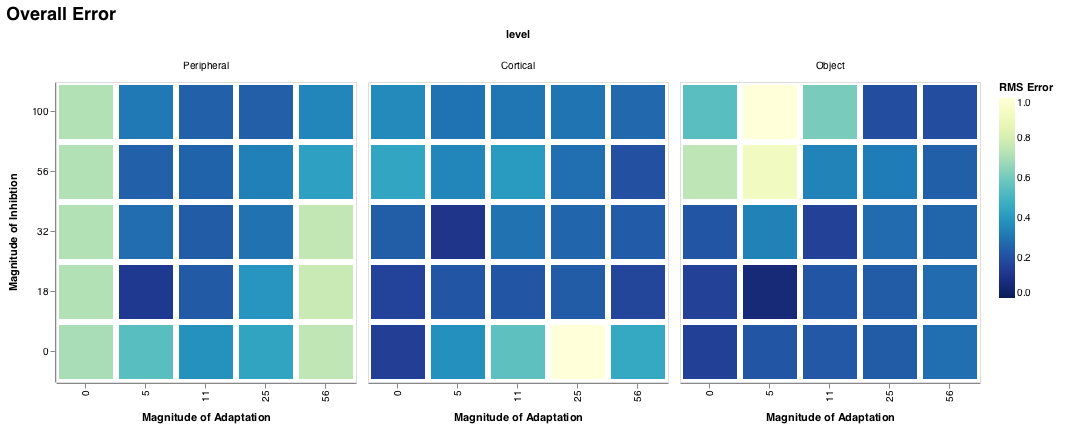

In [81]:
df_combined |>
  @vlplot(:rect, width=300, height=300,
          title={text="Overall Error",fontSize=18},
          column={field=:level, typ="nominal", sort=["Peripheral", "Cortical", "Object"]},
          x={field=:c_a, typ="ordinal", sort = "ascending",
             axis={title="Magnitude of Adaptation"}},
          y={field=:c_m, typ="ordinal", sort = "descending",
             axis={title="Magnitude of Inhibtion"}},
          color={field="rms", aggregate="mean", typ="quantitative", sort="descending",
                 legend={title="RMS Error"}, scale={domain = [0,1]}},
          config={range={heatmap={scheme="yellowgreenblue"}},
                  invalidValues="filter"})

# individual trials

In [253]:
selection = @where(params,(abs.(:t_c_m .- 18) .< 1) .& (abs.(:t_c_a .- 5) .< 5) .& (:Δf .== 6))[:pindex][1]

182

In [254]:
df = @transform(df,nlength = :length ./ mean(:length));

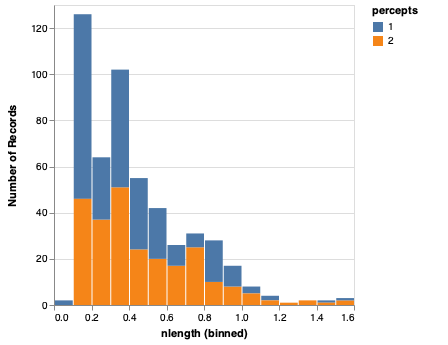

In [255]:
@where(df,(:pindex .== selection)) |>
   @vlplot(:bar, width=300, height=300, x={:nlength, bin={step=0.1}}, y="count()",
           color={field=:percepts, typ="nominal"})

In [126]:
masks = []
for_results_in(joinpath(datadir,"data")) do entry
    if entry["pindex"] == selection
        push!(masks,entry["mask"])
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


In [7]:
using PlotAxes

In [82]:
using ShiftedArrays

┌ Warning: Some of the frequency channels are missing.
└ @ ShammaModel /Users/davidlittle/.julia/packages/ShammaModel/wrlS1/src/audiospect.jl:145


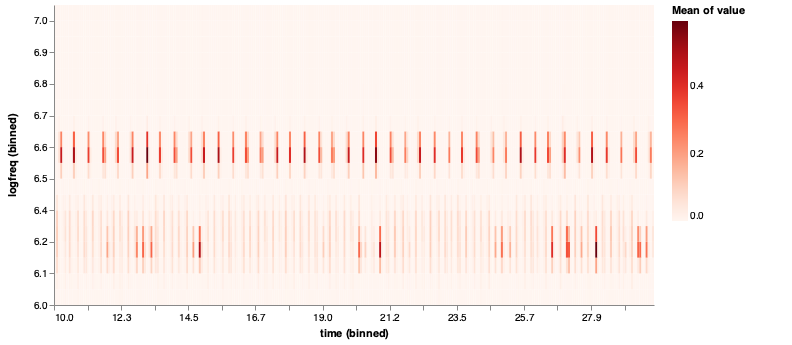

In [127]:
vlplot_axes(audiospect(masks[1],settings)[10s .. 30s],width=600,quantize_size=(300,100))

In [129]:
l,v = percept_lengths(audiospect(masks[1],settings)[10s .. 30s],audiospect_stimulus(params[selection,:],settings)[10s .. 30s,0.4kHz .. 1.2kHz],settings)
dfl = DataFrame(value=[v[1];v],time=10.0.+[0;cumsum(l)]);
dfl = @transform(dfl,lagtime = lag(:time,default=10));

┌ Warning: Some of the frequency channels are missing.
└ @ ShammaModel /Users/davidlittle/.julia/packages/ShammaModel/wrlS1/src/audiospect.jl:145
┌ Info: Stimulus is 47.999875 seconds long.
└ @ AuditoryBistabilityLE /Users/davidlittle/.julia/packages/AuditoryBistabilityLE/FHhPB/src/stim.jl:43


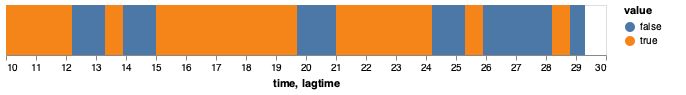

In [130]:
dfl |> @vlplot(mark=:rect,width=600,height=50,x={field=:time,scale={zero=false}},x2=:lagtime,color={field=:value,typ="nominal"})

In [ ]:
# use the original `df` to find the percent streaming for each stimulus for a given parameter setting

In [131]:
selection = @where(params,(abs.(:t_c_m .- 18) .< 1) .& (abs.(:t_c_a .- 5) .< 5))[:pindex]

3-element Array{Int64,1}:
 157
 182
 207

In [218]:
using DependentBootstrap
using CSV

┌ Info: Recompiling stale cache file /Users/davidlittle/.julia/compiled/v1.0/CSV/HHBkp.ji for CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1190


In [137]:
dbootconf(randn(100),alpha=0.25)[1]

0.061956632293417434

In [222]:
dfstream = @linq df |>
    where(in.(:pindex,Ref(selection))) |>
    by([:pindex,:created],
        streaming = sum(:length.*(:percepts .- 1))/sum(:length)) |>
    by(:pindex,
       mean = mean(:streaming),
       lowerc = dbootconf(:streaming)[1],
       upperc = dbootconf(:streaming)[2])
dfstream[:st] = [3,6,12]
dfstream[:experiment] = "simulation"
dfstream

3×6 DataFrame
│ Row │ pindex │ mean      │ lowerc    │ upperc    │ st    │ experiment │
│     │ Int64  │ Float64   │ Float64   │ Float64   │ Int64 │ String     │
├─────┼────────┼───────────┼───────────┼───────────┼───────┼────────────┤
│ 1   │ 157    │ 0.0434461 │ 0.0365724 │ 0.0504228 │ 3     │ simulation │
│ 2   │ 182    │ 0.527696  │ 0.509186  │ 0.546221  │ 6     │ simulation │
│ 3   │ 207    │ 0.859619  │ 0.843023  │ 0.876221  │ 12    │ simulation │

In [223]:
dfhuman = @linq CSV.read(joinpath("..","analysis","context","stream_prop.csv")) |>
    by(:st,
       mean = mean(:response),
       lowerc = dbootconf(collect(skipmissing(:response)))[1],
       upperc = dbootconf(collect(skipmissing(:response)))[2])
dfhuman[:experiment] = "human"
dfhuman

3×5 DataFrame
│ Row │ st     │ mean     │ lowerc   │ upperc   │ experiment │
│     │ Int64⍰ │ Float64  │ Float64  │ Float64  │ String     │
├─────┼────────┼──────────┼──────────┼──────────┼────────────┤
│ 1   │ 3      │ 0.15     │ 0.084537 │ 0.20679  │ human      │
│ 2   │ 6      │ 0.559259 │ 0.446914 │ 0.661775 │ human      │
│ 3   │ 12     │ 0.89321  │ 0.828395 │ 0.943241 │ human      │

In [225]:
delete!(dfstream,:pindex)
dfstream = vcat(dfstream,dfhuman)

6×5 DataFrame
│ Row │ mean      │ lowerc    │ upperc    │ st     │ experiment │
│     │ Float64   │ Float64   │ Float64   │ Int64⍰ │ String     │
├─────┼───────────┼───────────┼───────────┼────────┼────────────┤
│ 1   │ 0.0434461 │ 0.0365724 │ 0.0504228 │ 3      │ simulation │
│ 2   │ 0.527696  │ 0.509186  │ 0.546221  │ 6      │ simulation │
│ 3   │ 0.859619  │ 0.843023  │ 0.876221  │ 12     │ simulation │
│ 4   │ 0.15      │ 0.084537  │ 0.20679   │ 3      │ human      │
│ 5   │ 0.559259  │ 0.446914  │ 0.661775  │ 6      │ human      │
│ 6   │ 0.89321   │ 0.828395  │ 0.943241  │ 12     │ human      │

In [234]:
dfstream = @transform(dfstream,pos = @.(log(:st)/log(2) - ifelse(:experiment == "human",0.05,-0.05)))

6×6 DataFrame
│ Row │ mean      │ lowerc    │ upperc    │ st     │ experiment │ pos     │
│     │ Float64   │ Float64   │ Float64   │ Int64⍰ │ String     │ Float64 │
├─────┼───────────┼───────────┼───────────┼────────┼────────────┼─────────┤
│ 1   │ 0.0434461 │ 0.0365724 │ 0.0504228 │ 3      │ simulation │ 1.63496 │
│ 2   │ 0.527696  │ 0.509186  │ 0.546221  │ 6      │ simulation │ 2.63496 │
│ 3   │ 0.859619  │ 0.843023  │ 0.876221  │ 12     │ simulation │ 3.63496 │
│ 4   │ 0.15      │ 0.084537  │ 0.20679   │ 3      │ human      │ 1.53496 │
│ 5   │ 0.559259  │ 0.446914  │ 0.661775  │ 6      │ human      │ 2.53496 │
│ 6   │ 0.89321   │ 0.828395  │ 0.943241  │ 12     │ human      │ 3.53496 │

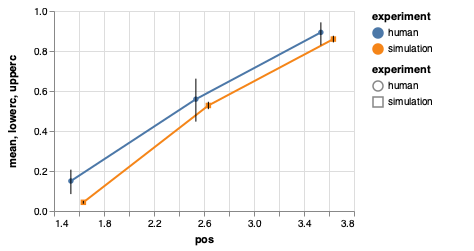

In [242]:
dfstream |> 
    @vlplot() +
    @vlplot(mark={:line,point=true},
        width=300,height=200,x="pos:q",
        y={field=:mean,typ="quantitative",scale={domain=[0,1]}},
        color="experiment:n", shape="experiment:n") +
    @vlplot(:rule,y="lowerc:q",y2="upperc:o",x="pos:q")

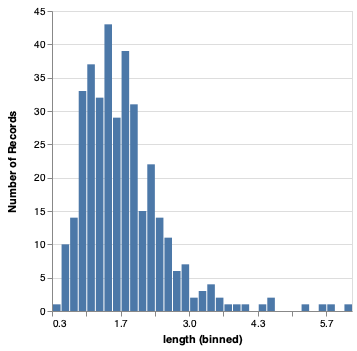

In [274]:
ph = CSV.read(joinpath("..","data","pressnitzer_hupe","pressnitzer_hupe_inferred.csv"))
ph |> @vlplot(:bar, width=300, height=300, x={:length,bin={step=0.16666}}, y="count()")

In [275]:
dfs = @where(df,(:pindex .== selection))
dflens = vcat(DataFrame(length = dfs[:nlength],experiment="simulation"),DataFrame(length = ph[:length],experiment="human"));

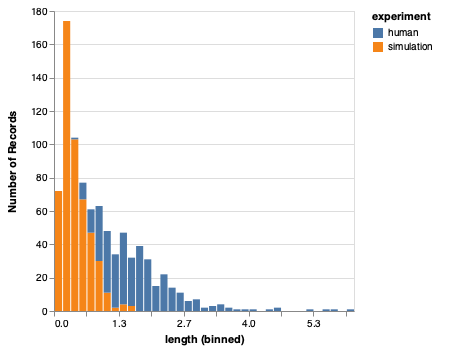

In [277]:
dflens |>
   @vlplot(:bar, width=300, height=300, x={:length, bin={step=0.16666}}, y="count()",
           color={field=:experiment, typ="nominal"})

# Thoughts

This is interesting; the variance in the human data is greater (might suggest multiple sources, consistnet with earlier reports).

That said, it is really distracting from the point I'm trying to caputre at this stage of the analysis. I can image this plot going somewhere else... OR
normalizing by the variance in some way, so that we can determine the extent to which we can match that... for the moment that seems like a reasonable standard.

In [311]:
dflens = @linq dflens |>
    groupby(:experiment) |>
    transform(nlength = exp.(zscore(log.(:length))))

878×5 DataFrame
│ Row │ length   │ experiment │ lse      │ nlength  │ log_len │
│     │ Float64⍰ │ String     │ Float64  │ Float64  │ Float64 │
├─────┼──────────┼────────────┼──────────┼──────────┼─────────┤
│ 1   │ 1.11164  │ simulation │ 0.640289 │ 5.86408  │ 15.3645 │
│ 2   │ 0.260171 │ simulation │ 0.640289 │ 0.606971 │ 3.59594 │
│ 3   │ 0.118259 │ simulation │ 0.640289 │ 0.177163 │ 1.63452 │
│ 4   │ 0.37843  │ simulation │ 0.640289 │ 1.08972  │ 5.23045 │
│ 5   │ 0.473037 │ simulation │ 0.640289 │ 1.54407  │ 6.53807 │
│ 6   │ 0.543993 │ simulation │ 0.640289 │ 1.92073  │ 7.51878 │
│ 7   │ 0.260171 │ simulation │ 0.640289 │ 0.606971 │ 3.59594 │
│ 8   │ 0.212867 │ simulation │ 0.640289 │ 0.443667 │ 2.94213 │
│ 9   │ 0.189215 │ simulation │ 0.640289 │ 0.36912  │ 2.61523 │
│ 10  │ 1.18259  │ simulation │ 0.640289 │ 6.45905  │ 16.3452 │
⋮
│ 868 │ 3.5      │ human      │ 0.46717  │ 6.46789  │ 1.40832 │
│ 869 │ 3.66667  │ human      │ 0.46717  │ 7.1451   │ 1.47538 │
│ 870 │ 3.83333  │ human      │ 0.46717  │ 7.85836  │ 1.54244 │
│ 871 │ 4.0      │ human      │ 0.46717  │ 8.60789  │ 1.6095  │
│ 872 │ 4.33333  │ human      │ 0.46717  │ 10.2166  │ 1.74363 │
│ 873 │ 4.5      │ human      │ 0.46717  │ 11.0762  │ 1.81069 │
│ 874 │ 4.5      │ human      │ 0.46717  │ 11.0762  │ 1.81069 │
│ 875 │ 5.16667  │ human      │ 0.46717  │ 14.8874  │ 2.07894 │
│ 876 │ 5.5      │ human      │ 0.46717  │ 17.0192  │ 2.21307 │
│ 877 │ 5.66667  │ human      │ 0.46717  │ 18.1423  │ 2.28013 │
│ 878 │ 6.0      │ human      │ 0.46717  │ 20.5035  │ 2.41426 │

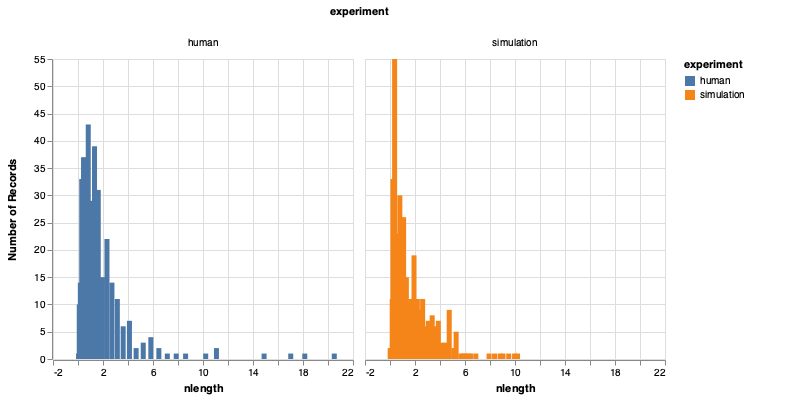

In [315]:
dflens |>
   @vlplot(:bar, width=300, height=300, x=:nlength, y="count()",
           color={field=:experiment, typ="nominal"}, column=:experiment)

# TODO:
- make it possible to include the human data next to the % streaming, and the histogram
- combine all of these plots together (for now, something dead simple)
- make it possible to call this combined plot on a given set of parameter values
- define an RMS measure on the basis of the histogram alone?
- start taking a look at the new data (from the 11-16 run)

In [10]:
selection = @where(params,(abs.(:f_c_m .- 18) .< 1) .& (abs.(:f_c_a .- 5) .< 1) .& (:Δf .== 6))[:pindex][1]

32

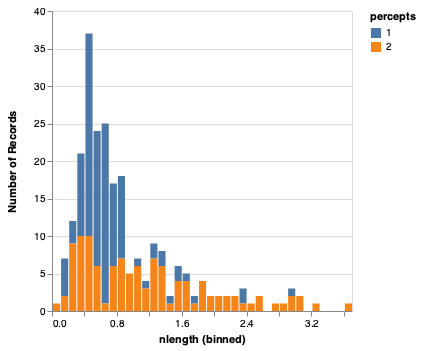

In [11]:
@where(df,(:pindex .== selection) .& (:length .< 20)) |>
   @vlplot(:bar, width=300, height=300, x={:nlength, bin={step=0.1}}, y="count()",
           color={field=:percepts, typ="nominal"})

In [12]:
masks = []
for_results_in(joinpath(datadir,"data")) do entry
    if entry["pindex"] == selection
        push!(masks,entry["mask"])
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


In [13]:
using PlotAxes

┌ Info: Stimulus is 47.999875 seconds long.
└ @ AuditoryBistabilityLE /Users/davidlittle/.julia/packages/AuditoryBistabilityLE/FHhPB/src/stim.jl:43


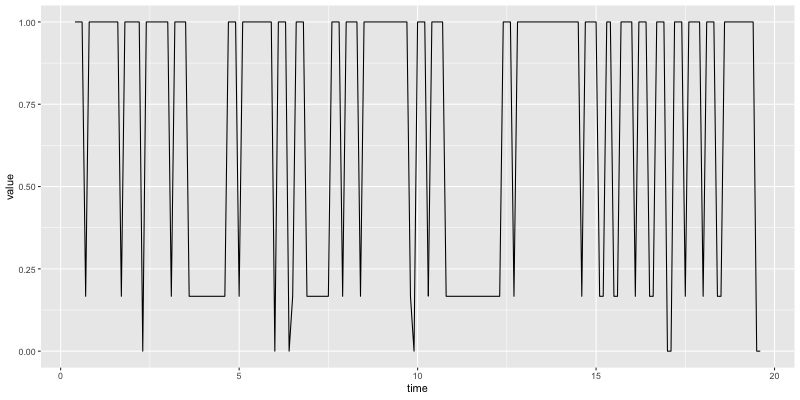

RObject{VecSxp}


In [14]:
rplot(bandwidth_ratio(AuditoryBistabilityLE.decompress(masks[1])[10s .. 30s],audiospect_stimulus(params[selection,:],settings)[10s .. 30s,0.4kHz .. 1.2kHz],settings)[1])

In [32]:
selection = @where(params,(abs.(:f_c_m .- 18) .< 1) .& (abs.(:f_c_a .- 11) .< 1) .& (:Δf .== 6))[:pindex][1]

37

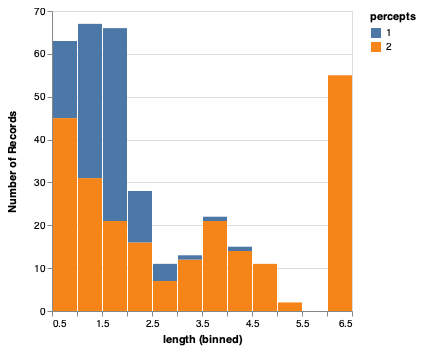

In [34]:
@where(df,(:pindex .== selection) .& (:length .< 20)) |>
   @vlplot(:bar, width=300, height=300, x={:length, bin={step=0.5}}, y="count()",
           color={field=:percepts, typ="nominal"})

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


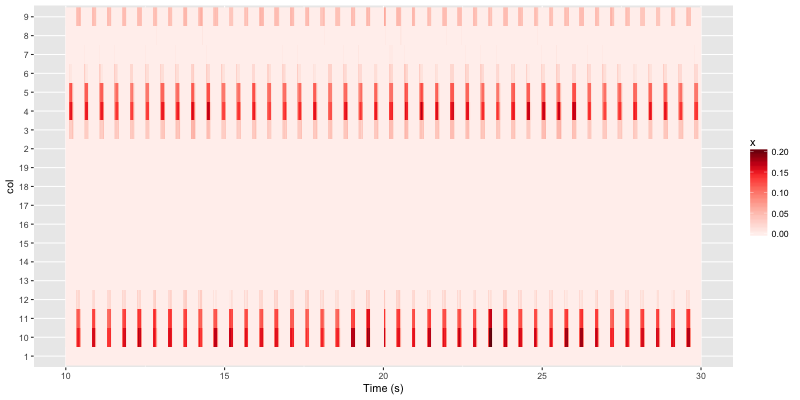

RObject{VecSxp}


In [155]:
masks = []
for_results_in(joinpath(datadir,"data")) do entry
    if entry["pindex"] == selection
        push!(masks,entry["mask"])
    end
end

rplot(AuditoryBistabilityLE.decompress(masks[1])[10s .. 30s])

In [156]:
selection = @where(params,(abs.(:f_c_m .- 100) .< 1) .& (abs.(:f_c_a .- 5) .< 1) .& (:Δf .== 6))[:pindex][1]

35

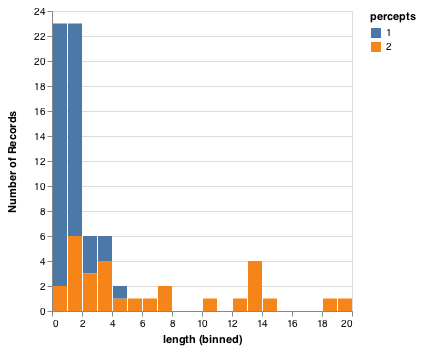

In [157]:
@where(df,(:pindex .== selection) .& (:length .< 20)) |>
   @vlplot(:bar, width=300, height=300, x={:length, bin={step=1.0}}, y="count()",
           color={field=:percepts, typ="nominal"})

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


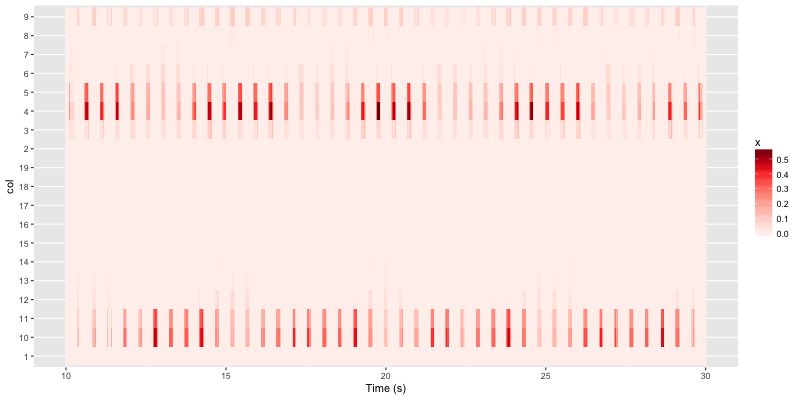

RObject{VecSxp}


In [158]:
masks = []
for_results_in(joinpath(datadir,"data")) do entry
    if entry["pindex"] == selection
        push!(masks,entry["mask"])
    end
end

rplot(AuditoryBistabilityLE.decompress(masks[1])[10s .. 30s])

In [35]:
selection = @where(params,(abs.(:s_c_m .- 56) .< 1) .& (abs.(:s_c_a .- 11) .< 1) .& (:Δf .== 6))[:pindex][1]

114

WARN column encoding should be discrete (ordinal / nominal / binned).
WARN column encoding should be discrete (ordinal / nominal / binned).


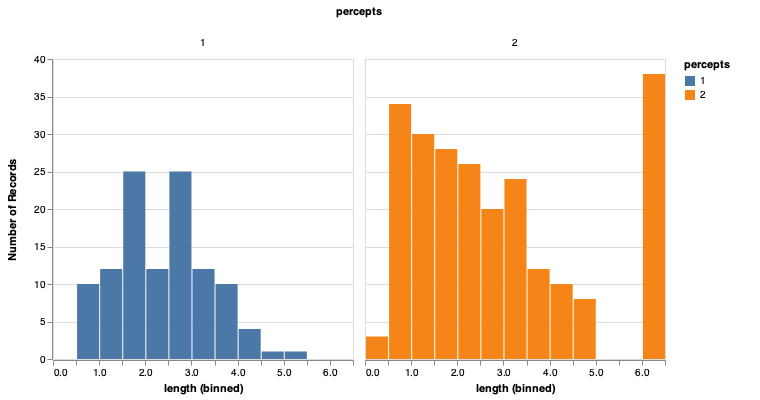

In [39]:
@where(df,(:pindex .== selection) .& (:length .< 20)) |>
   @vlplot(:bar, width=300, height=300, x={:length, bin={step=0.5}}, y="count()", column=:percepts,
           color={field=:percepts, typ="nominal"})

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


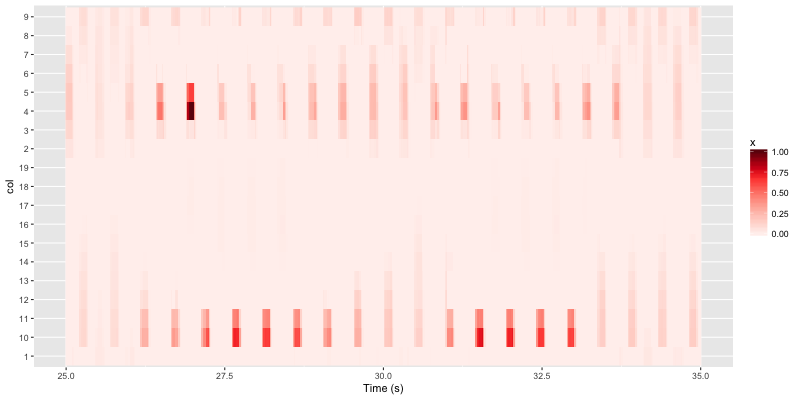

RObject{VecSxp}


In [161]:
masks = []
for_results_in(joinpath(datadir,"data")) do entry
    if entry["pindex"] == selection
        push!(masks,entry["mask"])
    end
end

rplot(AuditoryBistabilityLE.decompress(masks[1])[25s .. 35s])

In [77]:
selection = @where(params,(abs.(:s_c_m .- 32) .< 1) .& (abs.(:s_c_a .- 5) .< 1) .& (:Δf .== 6))[:pindex][1]

108

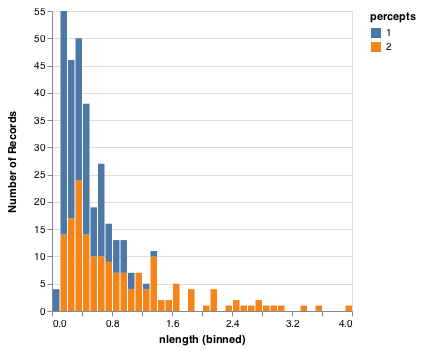

In [78]:
@where(df,(:pindex .== selection) .& (:length .< 20)) |>
   @vlplot(:bar, width=300, height=300, x={:nlength, bin={step=0.1}}, y="count()",
           color={field=:percepts, typ="nominal"})

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


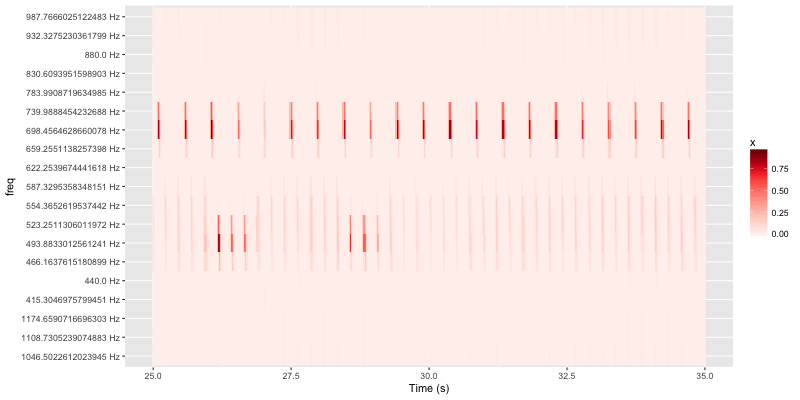

RObject{VecSxp}


In [79]:
masks = []
for_results_in(joinpath(datadir,"data")) do entry
    if entry["pindex"] == selection
        push!(masks,entry["mask"])
    end
end

rplot(AuditoryBistabilityLE.decompress(masks[1])[25s .. 35s])

┌ Info: Stimulus is 47.999875 seconds long.
└ @ AuditoryBistabilityLE /Users/davidlittle/.julia/packages/AuditoryBistabilityLE/9UMGt/src/stim.jl:43


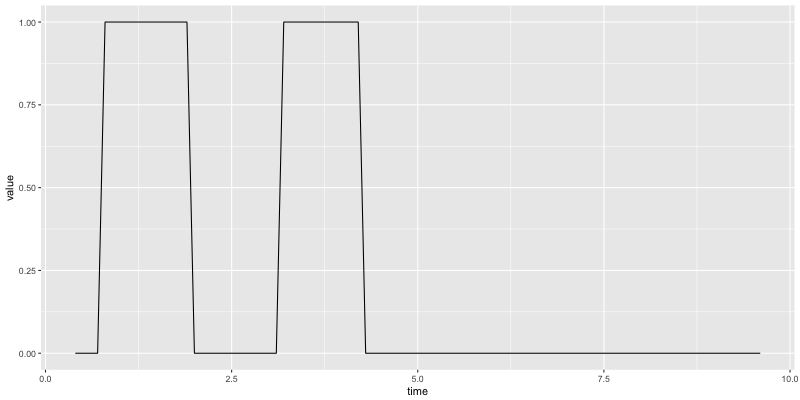

RObject{VecSxp}


In [80]:
rplot(bandwidth_ratio(AuditoryBistabilityLE.decompress(masks[1])[25s .. 35s],audiospect_stimulus(params[selection,:],settings)[25s .. 35s,0.4kHz .. 1.2kHz],settings)[1])

In [15]:
selection = @where(params,(abs.(:t_c_m .- 18) .< 1) .& (abs.(:t_c_a .- 56) .< 1) .& (:Δf .== 6))[:pindex][1]

185

In [22]:
@where(df,(:pindex .== selection) .& (:length .< 20))

364×4 DataFrame
│ Row │ length  │ percepts │ created                 │ pindex │
│     │ Float64 │ Bool     │ DateTime                │ Int64  │
├─────┼─────────┼──────────┼─────────────────────────┼────────┤
│ 1   │ 2.6     │ false    │ 2018-11-10T19:18:24.768 │ 185    │
│ 2   │ 0.6     │ true     │ 2018-11-10T19:18:24.768 │ 185    │
│ 3   │ 2.3     │ false    │ 2018-11-10T19:18:24.768 │ 185    │
│ 4   │ 0.5     │ true     │ 2018-11-10T19:18:24.768 │ 185    │
│ 5   │ 1.2     │ false    │ 2018-11-10T19:18:25.514 │ 185    │
│ 6   │ 0.6     │ true     │ 2018-11-10T19:18:25.514 │ 185    │
│ 7   │ 2.7     │ false    │ 2018-11-10T19:18:25.514 │ 185    │
│ 8   │ 1.5     │ true     │ 2018-11-10T19:18:25.514 │ 185    │
│ 9   │ 1.8     │ false    │ 2018-11-10T19:18:26.298 │ 185    │
│ 10  │ 0.8     │ true     │ 2018-11-10T19:18:26.298 │ 185    │
⋮
│ 354 │ 4.4     │ false    │ 2018-11-10T19:20:18.508 │ 185    │
│ 355 │ 0.9     │ true     │ 2018-11-10T19:20:18.508 │ 185    │
│ 356 │ 0.7     │ false    │ 2018-11-10T19:20:18.508 │ 185    │
│ 357 │ 2.0     │ false    │ 2018-11-10T19:20:19.252 │ 185    │
│ 358 │ 0.6     │ true     │ 2018-11-10T19:20:19.252 │ 185    │
│ 359 │ 2.1     │ false    │ 2018-11-10T19:20:19.252 │ 185    │
│ 360 │ 1.3     │ true     │ 2018-11-10T19:20:19.252 │ 185    │
│ 361 │ 2.5     │ false    │ 2018-11-10T19:20:20.008 │ 185    │
│ 362 │ 0.7     │ true     │ 2018-11-10T19:20:20.008 │ 185    │
│ 363 │ 1.2     │ false    │ 2018-11-10T19:20:20.008 │ 185    │
│ 364 │ 1.6     │ true     │ 2018-11-10T19:20:20.008 │ 185    │

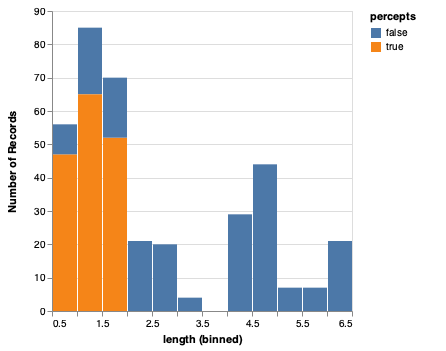

In [16]:
@where(df,(:pindex .== selection) .& (:length .< 20)) |>
   @vlplot(:bar, width=300, height=300, x={:length, bin={step=0.5}}, y="count()",
           color={field=:percepts, typ="nominal"})

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


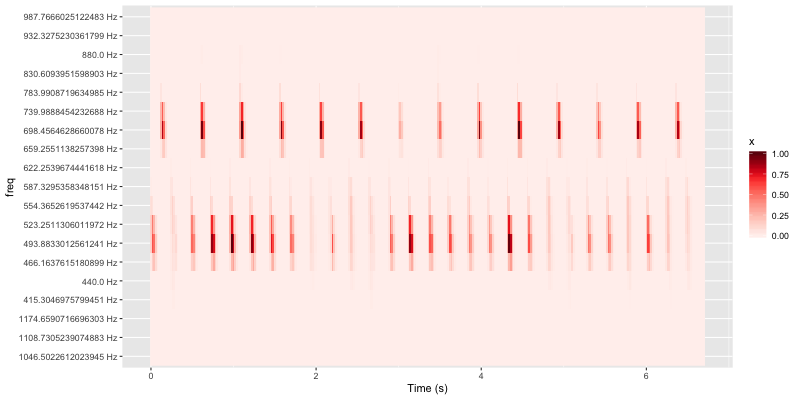

RObject{VecSxp}


In [17]:
masks = []
for_results_in(joinpath(datadir,"data")) do entry
    if entry["pindex"] == selection
        push!(masks,entry["mask"])
    end
end

rplot(AuditoryBistabilityLE.decompress(masks[1]))

In [18]:
@where(df,:pindex .== selection)

364×4 DataFrame
│ Row │ length  │ percepts │ created                 │ pindex │
│     │ Float64 │ Bool     │ DateTime                │ Int64  │
├─────┼─────────┼──────────┼─────────────────────────┼────────┤
│ 1   │ 2.6     │ false    │ 2018-11-10T19:18:24.768 │ 185    │
│ 2   │ 0.6     │ true     │ 2018-11-10T19:18:24.768 │ 185    │
│ 3   │ 2.3     │ false    │ 2018-11-10T19:18:24.768 │ 185    │
│ 4   │ 0.5     │ true     │ 2018-11-10T19:18:24.768 │ 185    │
│ 5   │ 1.2     │ false    │ 2018-11-10T19:18:25.514 │ 185    │
│ 6   │ 0.6     │ true     │ 2018-11-10T19:18:25.514 │ 185    │
│ 7   │ 2.7     │ false    │ 2018-11-10T19:18:25.514 │ 185    │
│ 8   │ 1.5     │ true     │ 2018-11-10T19:18:25.514 │ 185    │
│ 9   │ 1.8     │ false    │ 2018-11-10T19:18:26.298 │ 185    │
│ 10  │ 0.8     │ true     │ 2018-11-10T19:18:26.298 │ 185    │
⋮
│ 354 │ 4.4     │ false    │ 2018-11-10T19:20:18.508 │ 185    │
│ 355 │ 0.9     │ true     │ 2018-11-10T19:20:18.508 │ 185    │
│ 356 │ 0.7     │ false    │ 2018-11-10T19:20:18.508 │ 185    │
│ 357 │ 2.0     │ false    │ 2018-11-10T19:20:19.252 │ 185    │
│ 358 │ 0.6     │ true     │ 2018-11-10T19:20:19.252 │ 185    │
│ 359 │ 2.1     │ false    │ 2018-11-10T19:20:19.252 │ 185    │
│ 360 │ 1.3     │ true     │ 2018-11-10T19:20:19.252 │ 185    │
│ 361 │ 2.5     │ false    │ 2018-11-10T19:20:20.008 │ 185    │
│ 362 │ 0.7     │ true     │ 2018-11-10T19:20:20.008 │ 185    │
│ 363 │ 1.2     │ false    │ 2018-11-10T19:20:20.008 │ 185    │
│ 364 │ 1.6     │ true     │ 2018-11-10T19:20:20.008 │ 185    │

In [19]:
selection = @where(params,(abs.(:t_c_m .- 18) .< 1) .& (abs.(:t_c_a .- 56) .< 1) .& (:Δf .== 6))[:pindex][1]

185

In [ ]:
# NEXT STEP: get new bandwidth_ratio parameters working, and test them out

In [20]:
params_dict = Dict(k => params[selection,k] for k in names(params))
result = bistable_model(35,params_dict,joinpath("..","src","settings.toml"),interactive=true);

MethodError: MethodError: no method matching audiospect_stimulus(::NamedTuple{(:percept_lengths, :freqs, :mask, :rates, :scales, :stimulus, :track, :nmf, :bandwidth_ratio),Tuple{NamedTuple{(:threshold, :min_length_ms),Tuple{Float64,Int64}},NamedTuple{(:bistable, :analyze),Tuple{NamedTuple{(:lowpass, :lowpass_order, :input_bound),Tuple{Float64,Int64,Array{Float64,1}}},NamedTuple{(:delta_t_ms, :freq_step),Tuple{Int64,Int64}}}},NamedTuple{(:window_ms, :delta_ms),Tuple{Int64,Int64}},NamedTuple{(:rates_Hz, :bandonly, :freq_limits_Hz),Tuple{Array{Int64,1},Bool,Array{Float64,1}}},NamedTuple{(:bistable, :analyze),Tuple{NamedTuple{(:lowpass, :lowpass_order, :input_bound),Tuple{Float64,Int64,Array{Float64,1}}},NamedTuple{(:scales_cycoct, :bandonly),Tuple{Array{Float64,1},Bool}}}},NamedTuple{(:ramp_len_ms, :pattern, :tone_len_fraction),Tuple{Int64,String,Float64}},NamedTuple{(:bistable, :analyze),Tuple{NamedTuple{(:lowpass, :lowpass_order, :input_bound, :normalize_start_s),Tuple{Float64,Int64,Array{Float64,1},Float64}},NamedTuple{(:source_prior_strengths_s, :scale_ridge, :normalize, :time_constants_s, :max_sources, :freq_ridge, :source_prior_sds, :freq_prior_bias, :min_norm, :freq_prior_N),Tuple{Array{Int64,1},Float64,Bool,Array{Float64,1},Int64,Float64,Array{Float64,1},Int64,Float64,Int64}}}},NamedTuple{(:skipframes, :tol, :window_ms, :ncomponents, :maxiter, :delta_ms),Tuple{Int64,Float64,Int64,Int64,Int64,Int64}},NamedTuple{(:window_ms, :full_band_ratio, :threshold, :level_threshold, :delta_ms, :thresh_ratio),Tuple{Int64,Int64,Float64,Float64,Int64,Float64}}}}, ::Dict{Symbol,Number}; cache=true)
Closest candidates are:
  audiospect_stimulus(::Any, ::Any, !Matched::Any; cache) at /Users/davidlittle/googledrive/juliadev/AuditoryBistabilityLE/src/stim.jl:30

In [7]:
result.percepts.counts

([3.6, 3.6, 8.3, 0.6], Bool[false, true, false, true])

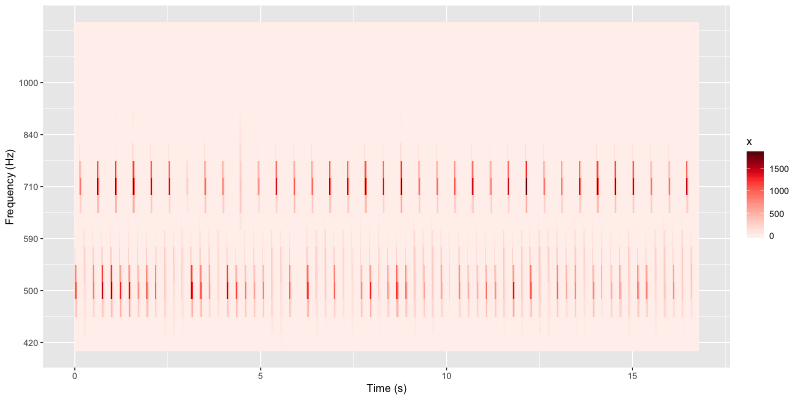

RObject{VecSxp}


In [8]:
rplot(result.primary_source)

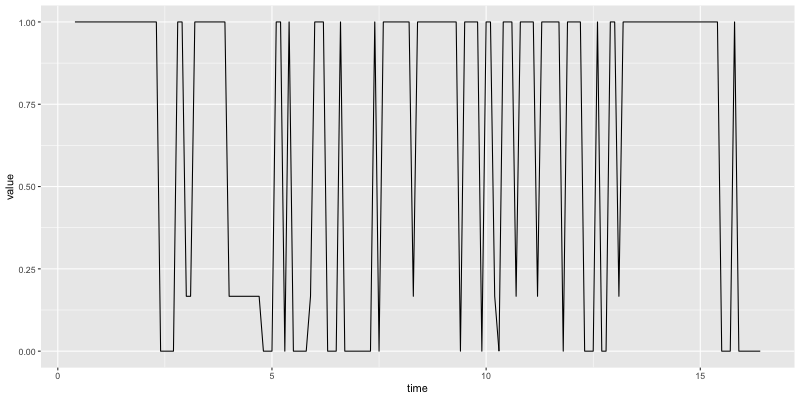

RObject{VecSxp}


In [9]:
rplot(result.percepts.ratio)

In [72]:
freqs(result.input[:,400Hz .. 1.2kHz])

19-element Array{Quantity{Float64,Unitful.Dimensions{(Unitful.Dimension{:Time}(-1//1),)},Unitful.FreeUnits{(Unitful.Unit{:Hertz,Unitful.Dimensions{(Unitful.Dimension{:Time}(-1//1),)}}(0, 1//1),),Unitful.Dimensions{(Unitful.Dimension{:Time}(-1//1),)}}},1}:
  415.3046975799451 Hz
              440.0 Hz
  466.1637615180899 Hz
  493.8833012561241 Hz
  523.2511306011972 Hz
  554.3652619537442 Hz
  587.3295358348151 Hz
  622.2539674441618 Hz
  659.2551138257398 Hz
  698.4564628660078 Hz
  739.9888454232688 Hz
  783.9908719634985 Hz
  830.6093951598903 Hz
              880.0 Hz
  932.3275230361799 Hz
  987.7666025122483 Hz
 1046.5022612023945 Hz
 1108.7305239074883 Hz
 1174.6590716696303 Hz

In [62]:
params_dict = Dict(k => params[selection,k] for k in names(params))
params_dict[:Δf] = 3
result = bistable_model(35,params_dict,joinpath("..","src","settings.toml"),interactive=true);

Temporal Coherence Analysis: 100%|██████████████████████| Time: 0:00:01
┌ Info: 0.6% of frames failed to fully converge to a solution.
└ @ AuditoryBistabilityLE /Users/davidlittle/googledrive/juliadev/AuditoryBistabilityLE/src/nmf.jl:45
Source Tracking (multi-prior):  84%|█████████████████   |  ETA: 0:00:00

fullchan


Source Tracking (multi-prior): 100%|████████████████████| Time: 0:00:01


maskchan


In [64]:
result.percepts.counts

([10.2, 0.7, 5.2], Bool[false, true, false])

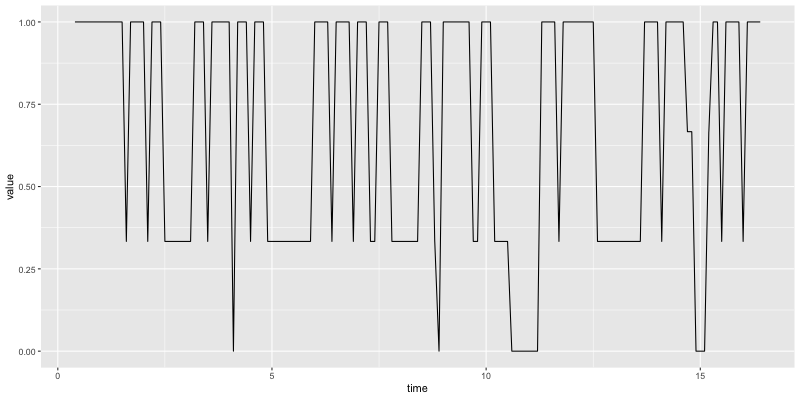

RObject{VecSxp}


In [63]:
rplot(result.percepts.ratio)

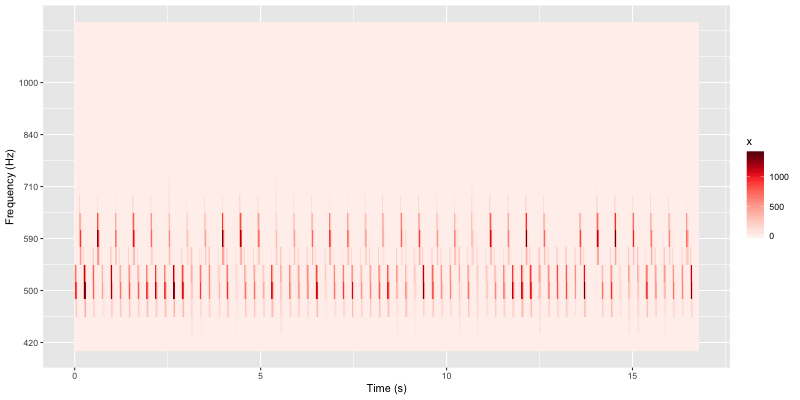

RObject{VecSxp}


In [65]:
rplot(result.primary_source)

In [66]:
params_dict = Dict(k => params[selection,k] for k in names(params))
params_dict[:Δf] = 12
result = bistable_model(35,params_dict,joinpath("..","src","settings.toml"),interactive=true);

Cortical Model: 100%|███████████████████████████████████| Time: 0:00:00
Temporal Coherence Analysis: 100%|██████████████████████| Time: 0:00:00
Source Tracking (multi-prior):  85%|█████████████████   |  ETA: 0:00:00

fullchan


Source Tracking (multi-prior): 100%|████████████████████| Time: 0:00:01


maskchan


In [69]:
result.percepts.counts

([1.1, 2.6, 0.8, 7.9, 0.8, 2.9], Bool[false, true, false, true, false, true])

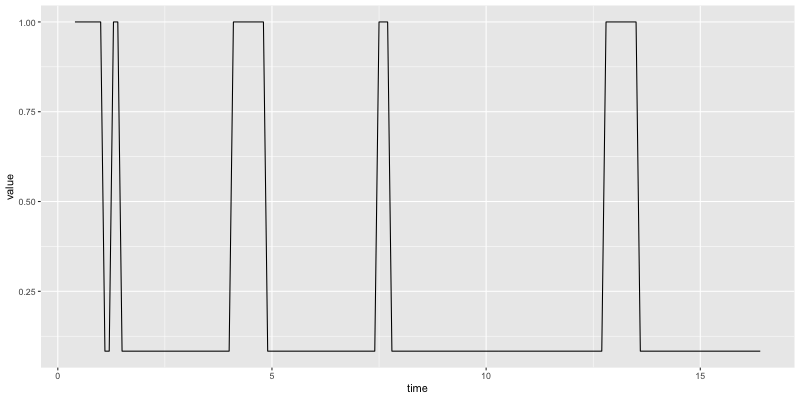

RObject{VecSxp}


In [67]:
rplot(result.percepts.ratio)

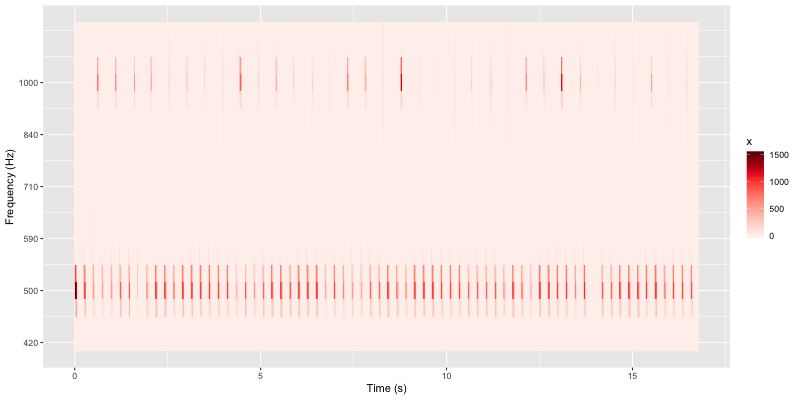

RObject{VecSxp}


In [68]:
rplot(result.primary_source)